# Phase 1A, Run SI for Optimal Beta values

NYT COVID-19 data found here:
https://github.com/nytimes/covid-19-data

Population data found here:
https://www.ers.usda.gov/data-products/county-level-data-sets/download-data/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Importing the NYT time series data into a dataframe covid19

In [11]:
covid19 = pd.read_csv('1A_DATA/us-counties.csv')

Importing the population data as pop_data

In [13]:
pop_data = pd.read_csv('1A_data/phase1_popdata.csv', encoding = 'ISO-8859-1')

# Defining the SIR simulation (SIRD with f = 0, r = 0)

In [5]:
def run_sir(population, b, numdays):   

  # values 
  D0 = 0
  I0 = 1
  R0 = 0
  S0 = population - I0 - D0 

  g = 1 / 14
  f = 0

# A grid of time points (in days)
  t = np.linspace(0, numdays, numdays + 1)

  S = S0
  I = I0
  R = R0
  D = D0

  S_list = [S0]
  I_list = [I0]
  R_list = [R0]
  D_list = [D0]

  for time in t[1:]:
      dSdt = (-1.0 * b * S * I)
      dIdt = (b * S * I) - (g * I)
      dDdt = g * f * I
      dRdt = ((1-f) * g * I)
      if (S + dSdt < 0):
            dSdt = -1 * S
            dIdt = S - (g * I)

      S = S + dSdt
      I = I + dIdt
      R = R + dRdt
      D = D + dDdt
      S_list.append(S)
      I_list.append(I)
      R_list.append(R)
      D_list.append(D)
  return S_list, I_list, R_list, D_list

# Defining the Objective Function for Optimization

In [6]:
from sklearn.metrics import mean_squared_error

# cases is the real data and I_test is the predicted time series data based on the SIRD model

def error_of_sim_1(cases, I_test):
    original = pd.DataFrame()
    original['cases'] = cases
    original['i_test'] = I_test
    return mean_squared_error(original['cases'], original['i_test'])


In [17]:
## Takes x = [initial beta]
##       args = (cases, population])

def objective_fun_1(x, *args):
    S, I, R, D = run_si(args[1], x, len(args[0]) - 1)
    result = error_of_sim_1(args[0], I)
    return result


unique_fips is a list of unique fips codes

In [14]:
unique_fips = covid19['fips'].unique()
unique_fips = [float(fips) for fips in unique_fips]
unique_fips = pd.Series(unique_fips).dropna()

# Here we optimize the SI model's cost function for each county (MSE for each day in number of cases summed up) and record the beta values.

In [18]:
from scipy.optimize import minimize

pop_data["beta"] = np.nan

for fips in unique_fips: 
      population = pop_data[pop_data.FIPS == fips]['POPESTIMATE2019']
      if(len(population) == 0):
        continue
      else:
        temp_col = covid19[covid19.fips == fips]
        if (len(temp_col) < 20):
            continue
        if(temp_col['deaths'].tail(n = 1).iloc[0] < 25):
            continue
        args = (temp_col['cases'], population.iloc[0])
        result = minimize(objective_fun_1, [.000002], args, method = 'Powell')
        pop_data.loc[pop_data.FIPS == fips, 'beta'] = result.x                                                                                                                                
      
      

Drop bad data and look at the head (note, we excluded counties with less than 20 days of Covid and less than 25 deaths)

In [19]:
pop_data = pop_data.dropna()
pop_data.head()

,Unnamed: 0,POPESTIMATE2019,FIPS,beta
37,37,658573,1073.0,3.582561e-07
41,41,164542,1081.0,1.353718e-06
49,49,413210,1097.0,6.400933e-07
101,101,143476,4005.0,1.660785e-06
106,106,4485414,4013.0,4.999949e-01


Looking at first few graphs

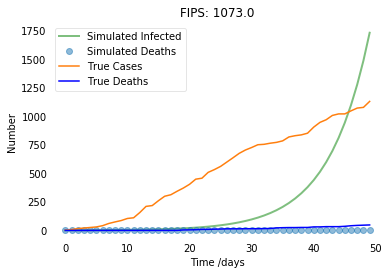

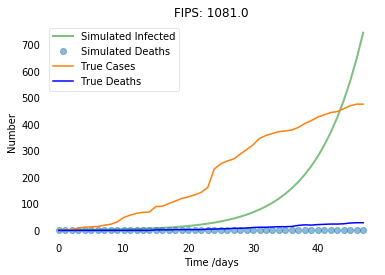

In [20]:
for index, row in pop_data.dropna().head(n = 2).iterrows():
    temp_col = covid19[covid19.fips == row['FIPS']]
    S, I, R, D = run_si(row['POPESTIMATE2019'], row["beta"], len(temp_col) - 1)
    t = np.linspace(0, len(temp_col)-1, len(temp_col))

    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(t, I, 'g', alpha=0.5, lw=2, label='Simulated Infected')
    ax.plot(t, D, 'o', alpha=0.5, lw=2, label='Simulated Deaths')


    ax.plot(t, temp_col['cases'] * (100/82.1), label = 'True Cases')
    ax.plot(t, temp_col['deaths'], 'b', label = 'True Deaths')

    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number')
    ax.set_title('FIPS: ' + str(row['FIPS']))

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

# EXPORT as phase1_betavalues.csv

In [21]:
pop_data.to_csv('1A_data/phase1_betavalues.csv')